In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import pandas as pd
import os
from sklearn.decomposition import PCA
from skspatial.objects import Line, Point
import math
from scipy.linalg import svd as svd
from scipy.linalg import eig as eig
import warnings
warnings.filterwarnings('ignore')

## Question 1.2

In [2]:
means = [[-1, -1],
         [1, -1],
         [0, 1]]
sigmas = [0.5, 1, 2, 4, 8]
covariances = [np.array([[2, 0.5], [0.5, 1]]),
               np.array([[1, -0.5], [-0.5, 2]]),
               np.array([[1, 0], [0, 2]])]

def generate_data(means, sigma, covariances):
    data = []
    for i in range(3):
        x0, x1 = np.random.multivariate_normal(means[i], sigma*covariances[i], 100).T
        for j in range(len(x0)):
            data.append([x0[j], x1[j], i])
    
    df = pd.DataFrame(data=data, columns=["x0", "x1", "y"])
        
    return df

def display_data(df):
    ax1 = df.plot.scatter(x='x0',y='x1', c='y', colormap="brg")
    
def get_distance(pt0, pt1):
    return np.sqrt((pt0[0] - pt1[0])**2 + (pt0[1] - pt1[1])**2)

def get_mapping(means, centroids):
    mapping = {}
    for i in range(len(centroids)):

        min_dist = 100
        mean_index = 0
        for j in range(len(means)):
            if get_distance(centroids[i], means[j]) < min_dist:
                min_dist = get_distance(centroids[i], means[j])
                mean_index = j
         
        mapping[i] = mean_index
        
    return mapping

def get_accuracy(means, centroids, reals, preds):
    mapping = get_mapping(means, centroids)
    
    acc = 0
    for real, pred in zip(reals, preds):
        if real == mapping[pred]:
            acc += 1
            
    return acc/len(reals)

def get_obj_val(df, means, centroids, preds):
    mapping = get_mapping(means, centroids)
    
    obj_val = 0
    
    for x0, x1, real, pred in zip(df["x0"], df["x1"], df["y"], preds):
        if real == mapping[pred]:
#             obj_val += math.dist([x0, x1], centroids[pred])**2
            obj_val += ((np.array([x0, x1]) - centroids[pred])**2).sum()
    
    return obj_val
    

def experiment(method, iterations=100):
    accuracies = [0] * len(sigmas)
    obj_vals = [0] * len(sigmas)
    scores = [0] * len(sigmas)
    
    for i in range(len(sigmas)):
        
        high_score = -1000000
        for j in range(iterations):
            df = generate_data(means, sigmas[i], covariances)
            
            if method == "kmeans":
                kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(df.drop('y', axis=1))
                accuracy = get_accuracy(means, kmeans.cluster_centers_, df['y'], kmeans.predict(df.drop('y', axis=1)))
                score = kmeans.score(df.drop('y', axis=1))
                obj_val = get_obj_val(df, means, kmeans.cluster_centers_, kmeans.predict(df.drop('y', axis=1)))
            
            if method == "gmm":
                gaussian_mixture = GaussianMixture(n_components=3).fit(df.drop('y', axis=1))
                accuracy = get_accuracy(means, gaussian_mixture.means_, df['y'], gaussian_mixture.predict(df.drop('y', axis=1)))
                score = gaussian_mixture.score(df.drop('y', axis=1))
                obj_val = get_obj_val(df, means, gaussian_mixture.means_, gaussian_mixture.predict(df.drop('y', axis=1)))
            
            if score > high_score:
                high_score = score
                accuracies[i] = accuracy
                obj_vals[i] = obj_val
                scores[i] = score

    return accuracies, obj_vals


In [3]:
kmeans_accuracies, kmeans_scores = experiment("kmeans")
gmm_accuracies, gmm_scores = experiment("gmm")

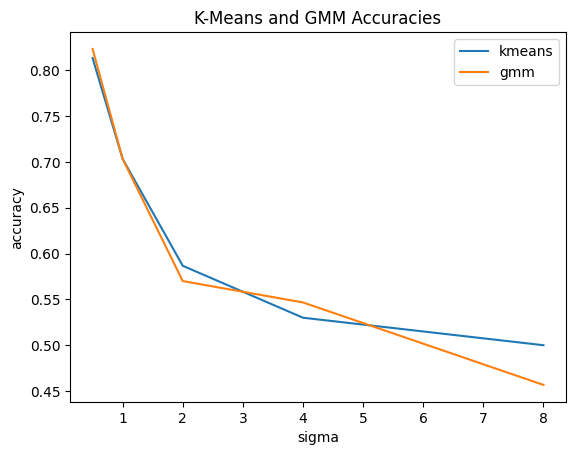

In [4]:
plt.plot(sigmas, kmeans_accuracies, label="kmeans")
plt.plot(sigmas, gmm_accuracies, label="gmm")
plt.title("K-Means and GMM Accuracies")
plt.legend()
plt.xlabel("sigma")
plt.ylabel("accuracy")
plt.savefig("Q1-2-accuracies.jpg")
plt.show()

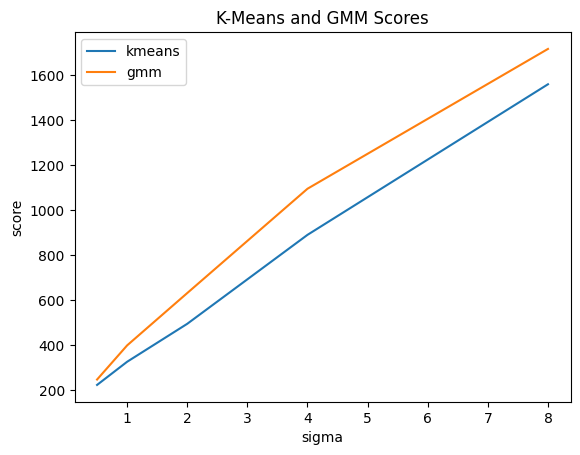

In [5]:
plt.plot(sigmas, kmeans_scores, label="kmeans")
plt.plot(sigmas, gmm_scores, label="gmm")
plt.title("K-Means and GMM Scores")
plt.legend()
plt.xlabel("sigma")
plt.ylabel("score")
plt.savefig("Q1-2-scores.jpg")
plt.show()

## Question 2.4

In [6]:
def read_file(filename):
    df = pd.read_csv(os.getcwd()+"/data/"+filename, sep=",", header=None)
    
    cols = []
    for i in range(df.shape[1]) :
        cols.append("x"+str(i))
        
    df.columns = cols

    return df

### - Buggy PCA

In [7]:
def buggy_pca(df, d):
    D = df.shape[1]
    u,s,v = svd(df, full_matrices=False)
    recon_df = pd.DataFrame()
    
    x = u[:, :d] @ np.diag(s[:d]) @ v[:d, :]
    
    for i in range(D):
        recon_df["x"+str(i)] = x[:,i]
        
#     recon_df = pd.DataFrame(x)
        
    return recon_df

def get_recon_error(df, recon_df):
    recon_error = 0
    for pt1, pt2 in zip(df.to_numpy(), recon_df.to_numpy()):
        recon_error += math.dist(pt1, pt2)**2/df.shape[0]
#         diff = pt1 - pt2
#         recon_error += np.sum(diff**2)/df.shape[0]

#     diff = df.to_numpy() - recon_df.to_numpy()
#     return np.sum(np.square(diff))/df.shape[0]

    return recon_error
    

In [8]:
df = read_file("data2D.csv")

recon_df = buggy_pca(df, 1)

print("reconstruction error: " + str(get_recon_error(df, recon_df)))

reconstruction error: 0.8869030837347941


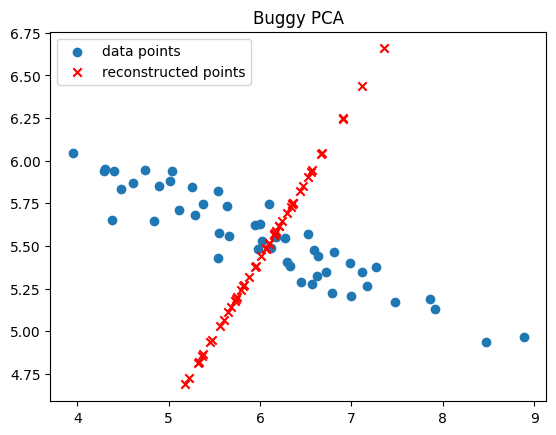

In [9]:
plt.scatter(df["x0"], df["x1"], label="data points")
plt.scatter(recon_df["x0"], recon_df["x1"], marker="x", c="red", label="reconstructed points")
plt.legend()
plt.title("Buggy PCA")
plt.savefig("buggy-pca-1.jpg")
plt.show()

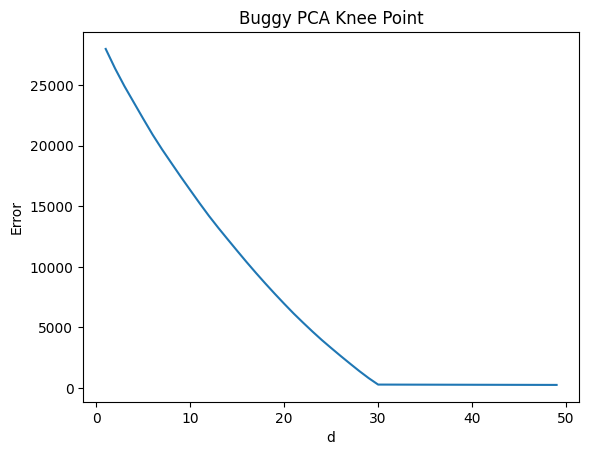

In [10]:
df = read_file("data1000D.csv")

recon_errors = []
for i in range(1,50):
    recon_df = buggy_pca(df, i+1)
    recon_errors.append(get_recon_error(df, recon_df))
    
plt.plot(range(1,50), recon_errors)
plt.title("Buggy PCA Knee Point")
plt.xlabel("d")
plt.ylabel("Error")
plt.savefig("buggy-pca-2.jpg")
plt.show()

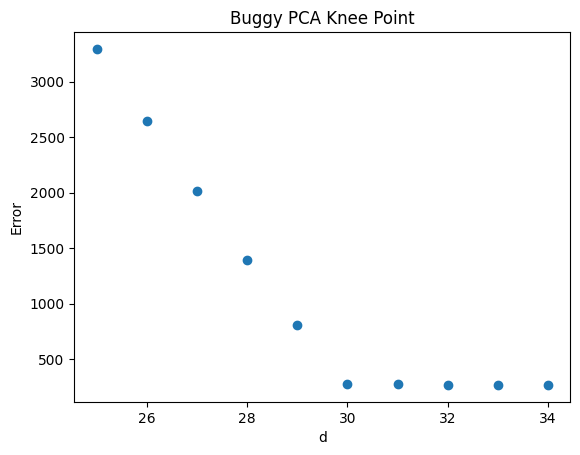

In [11]:
df = read_file("data1000D.csv")

recon_errors = []
for i in range(25,35):
    recon_df = buggy_pca(df, i+1)
    recon_errors.append(get_recon_error(df, recon_df))
    
plt.scatter(range(25,35), recon_errors)
plt.title("Buggy PCA Knee Point")
plt.xlabel("d")
plt.ylabel("Error")
plt.savefig("buggy-pca-3.jpg")
plt.show()

### - Demeaned PCA

In [12]:
def demeaned_pca(df, d):
    D = df.shape[1]
    recon_df = pd.DataFrame()
    
    normalized_df = pd.DataFrame()
    for col in df.columns:
        normalized_df[col] = (df[col] - df[col].mean())
            
    u,s,v = svd(normalized_df, full_matrices=False)    
    
    x = u[:, :d] @ np.diag(s[:d]) @ v[:d, :]
    
    for i in range(D):
        recon_df["x"+str(i)] = x[:,i]
    
    for col in recon_df.columns:
        recon_df[col] = recon_df[col] + df[col].mean()
    
    return recon_df

In [13]:
df = read_file("data2D.csv")

recon_df = demeaned_pca(df, 1)

print("reconstruction error: " + str(get_recon_error(df, recon_df)))

reconstruction error: 0.010006085628512908


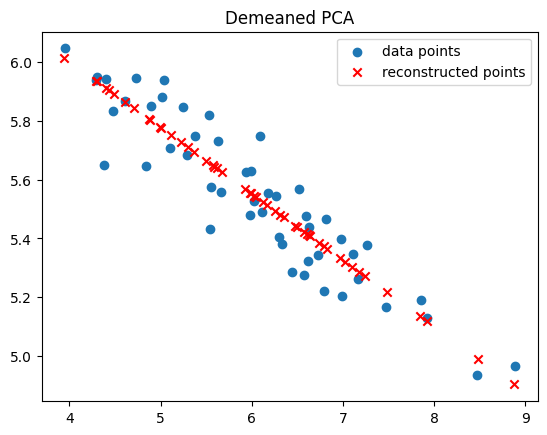

In [14]:
plt.scatter(df["x0"], df["x1"], label="data points")
plt.scatter(recon_df["x0"], recon_df["x1"], marker="x", c="red", label="reconstructed points")
plt.legend()
plt.title("Demeaned PCA")
plt.savefig("demeaned-pca-1.jpg")
plt.show()

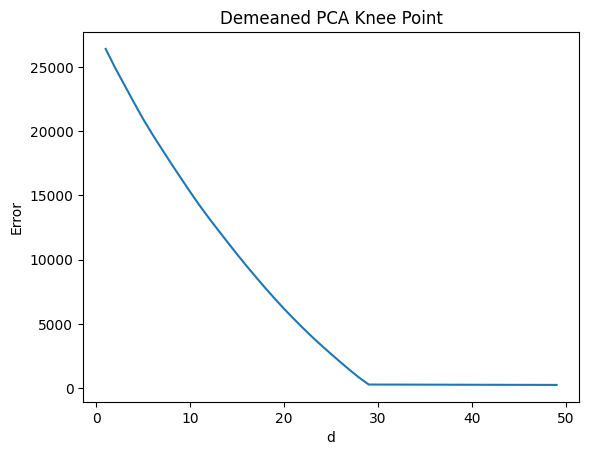

In [15]:
df = read_file("data1000D.csv")

recon_errors = []
for i in range(1,50):
    recon_df = demeaned_pca(df, i+1)
    recon_errors.append(get_recon_error(df, recon_df))
    
plt.plot(range(1,50), recon_errors)
plt.title("Demeaned PCA Knee Point")
plt.xlabel("d")
plt.ylabel("Error")
plt.savefig("demeaned-pca-2.jpg")
plt.show()

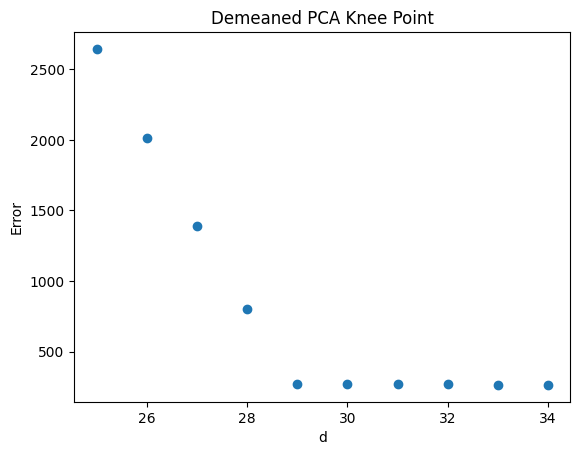

In [16]:
df = read_file("data1000D.csv")

recon_errors = []
for i in range(25,35):
    recon_df = demeaned_pca(df, i+1)
    recon_errors.append(get_recon_error(df, recon_df))
    
plt.scatter(range(25,35), recon_errors)
plt.title("Demeaned PCA Knee Point")
plt.xlabel("d")
plt.ylabel("Error")
plt.savefig("demeaned-pca-3.jpg")
plt.show()

### - Normalized PCA

In [17]:
def normalized_pca(df, d):
    D = df.shape[1]
    recon_df = pd.DataFrame()
    
    normalized_df = pd.DataFrame()
    for col in df.columns:
        normalized_df[col] = (df[col] - df[col].mean())/df[col].std()
            
    u,s,v = svd(normalized_df, full_matrices=False)    
    
    x = u[:, :d] @ np.diag(s[:d]) @ v[:d, :]
    
    for i in range(D):
        recon_df["x"+str(i)] = x[:,i]
    
    for col in recon_df.columns:
        recon_df[col] = recon_df[col] * df[col].std() + df[col].mean()
    
    return recon_df

In [18]:
df = read_file("data2D.csv")

recon_df = normalized_pca(df, 1)

print("reconstruction error: " + str(get_recon_error(df, recon_df)))

reconstruction error: 0.04947208345477061


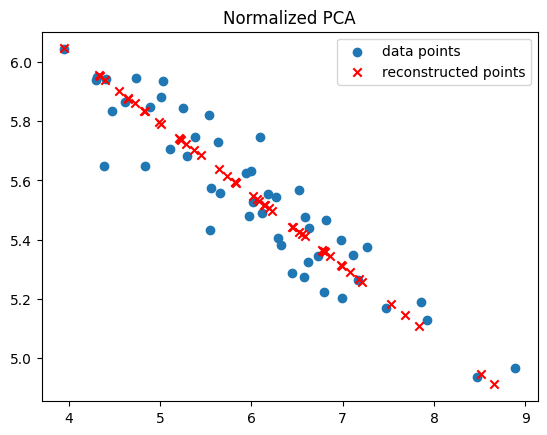

In [19]:
plt.scatter(df["x0"], df["x1"], label="data points")
plt.scatter(recon_df["x0"], recon_df["x1"], marker="x", c="red", label="reconstructed points")
plt.legend()
plt.title("Normalized PCA")
plt.savefig("normalized-pca-1.jpg")
plt.show()

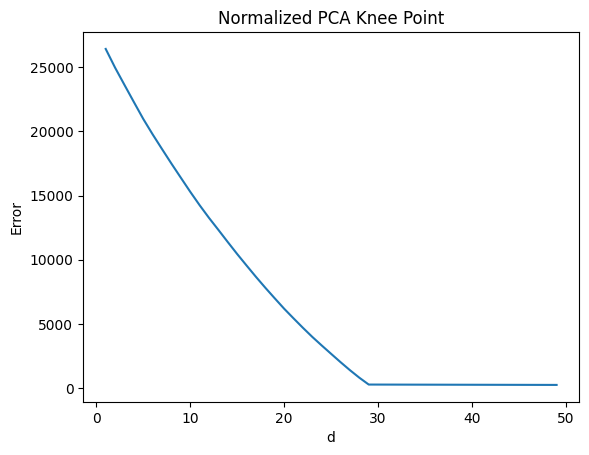

In [20]:
df = read_file("data1000D.csv")

recon_errors = []
for i in range(1,50):
    recon_df = normalized_pca(df, i+1)
    recon_errors.append(get_recon_error(df, recon_df))
    
plt.plot(range(1,50), recon_errors)
plt.title("Normalized PCA Knee Point")
plt.xlabel("d")
plt.ylabel("Error")
plt.savefig("normalized-pca-2.jpg")
plt.show()

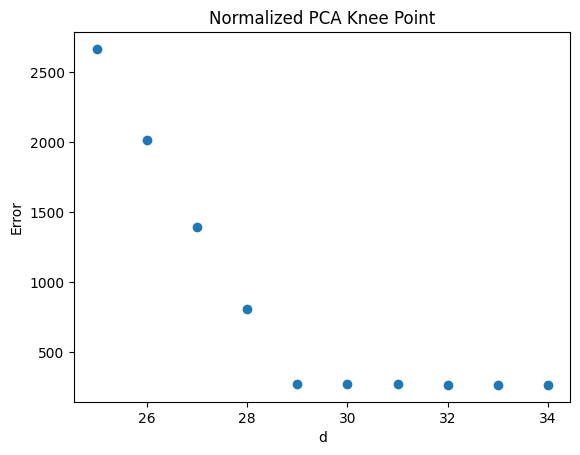

In [21]:
recon_errors = []
for i in range(25,35):
    recon_df = normalized_pca(df, i+1)
    recon_errors.append(get_recon_error(df, recon_df))
    
plt.scatter(range(25,35), recon_errors)
plt.title("Normalized PCA Knee Point")
plt.xlabel("d")
plt.ylabel("Error")
plt.savefig("normalized-pca-3.jpg")
plt.show()

### - DRO

In [22]:
def dro(df, d):
    n, D = df.shape
    x = df.to_numpy()
    demeaned_x = x - x.mean(axis=0)
    
    cov = np.cov(demeaned_x.T)
    e_vals, e_vecs = eig(cov)
    
    z = np.dot(demeaned_x, e_vecs[:, :d])
    
    recon = np.dot(z, e_vecs[:, :d].T) + x.mean(axis=0)
    recon_df = pd.DataFrame(recon)
    
    cols = []
    for i in range(recon_df.shape[1]) :
        cols.append("x"+str(i))
        
    recon_df.columns = cols
        
    return recon_df

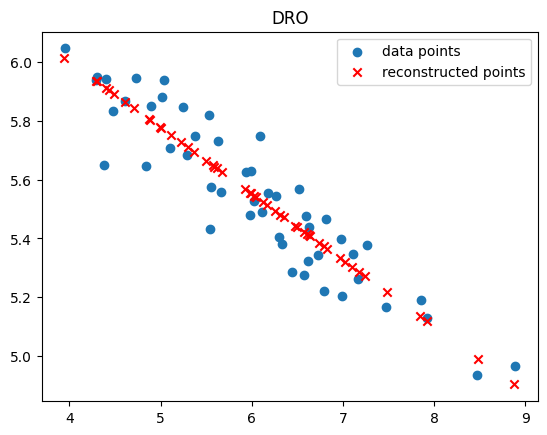

In [23]:
df = read_file("data2D.csv")
recon_df = dro(df, 1)

plt.scatter(df["x0"], df["x1"], label="data points")
plt.scatter(recon_df["x0"], recon_df["x1"], marker="x", c="red", label="reconstructed points")
plt.legend()
plt.title("DRO")
plt.savefig("dro-1.jpg")
plt.show()

In [24]:
print("reconstruction error: " + str(get_recon_error(df, recon_df)))

reconstruction error: 0.010006085628512905


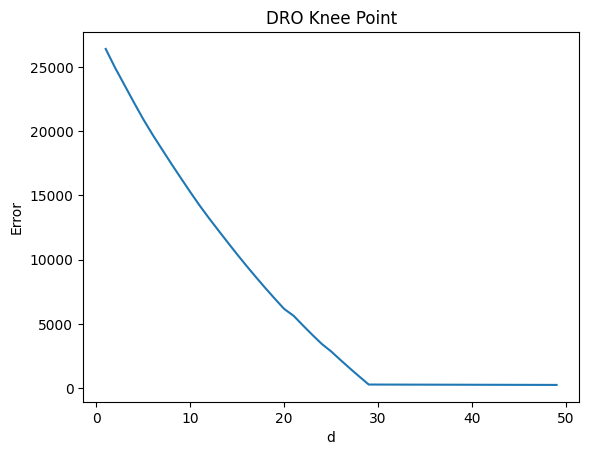

In [25]:
df = read_file("data1000D.csv")

recon_errors = []
for i in range(1,50):
    recon_df = dro(df, i+1)
    recon_errors.append(get_recon_error(df, recon_df))
    
plt.plot(range(1,50), recon_errors)
plt.title("DRO Knee Point")
plt.xlabel("d")
plt.ylabel("Error")
plt.savefig("DRO-2.jpg")
plt.show()

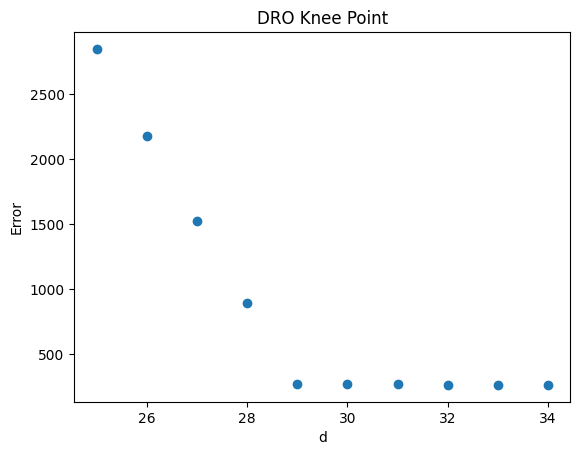

In [26]:
recon_errors = []
for i in range(25,35):
    recon_df = dro(df, i+1)
    recon_errors.append(get_recon_error(df, recon_df))
    
plt.scatter(range(25,35), recon_errors)
plt.title("DRO Knee Point")
plt.xlabel("d")
plt.ylabel("Error")
plt.savefig("DRO-3.jpg")
plt.show()